In [1]:
from pickletools import uint8

import numpy as np

from 直线检测.copy import *

In [8]:
def _get_k(line):
    x0, y0, x1, y1 = line
    if x1 - x0 == 0:
        return float('inf')
    return (y1 - y0) / (x1 - x0)


def _get_b(line):
    x0, y0, x1, y1 = line
    if x1 - x0 == 0:
        return float('inf')
    return y0 - _get_k(line) * x0

In [55]:
def _detect_one_img(img, cfg):
    """ 返回的是一堆合并完的线，而且上了颜色，线的性质暂时不是非常清楚 """

    alone = []         # 来自3月12日的更新，用来存储没有参与任何合并的线元
    # elines 返回值:带有斜率，颜色的线元
    elines = get_eline_faster(img, cfg)
    contours_img = get_contours(img)
    for eline in elines:
        cv2.line(contours_img, eline.pt1, eline.pt2, (255, 255, 255), 1)
    contours_eline = get_eline_faster(contours_img, cfg)
    elines = eliminate_distortion(elines + contours_eline, img.shape[:2])
    cfs = getlinks(elines, cfg)
    elines_group_by_line = []

    # 先遍历1-5纯血直线
    group_by_volume = {}
    for idx, eline in enumerate(elines):
        if eline.volume not in group_by_volume:
            group_by_volume[eline.volume] = []
        group_by_volume[eline.volume].append(idx)
    uf = UnionFind(len(elines))
    for it in range(1, 6):
        if it not in group_by_volume:
            continue
        for eline_idx in group_by_volume[it]:
            eline = elines[eline_idx]
            for eline2_idx in cfs.get_neighbors(eline_idx):
                eline2 = elines[eline2_idx]
                if (eline.color == eline2.color and eline.volume == eline2.volume and eline.dir_eq(eline2.dir)
                        and (eline.volume == 1 or (eline.k1 + eline2.k2) and (eline2.k1 + eline.k2))):
                    uf.union(eline_idx, eline2_idx)

    sets = uf.get_sets()
    # 剩余的线  用来再做一次上面的操作
    other_elines = []
    for i, set_ in enumerate(sets):
        if len(set_) >= cfg.MAX_CONTINUE:
            elines_group_by_line.append(set_)
        else:
            for j in set_:
                other_elines.append(j)

    # 混合遍历 , 大1 小1 等于
    group_by_volume = {}
    for idx in other_elines:
        eline = elines[idx]
        if eline.volume not in group_by_volume:
            group_by_volume[eline.volume] = []
        group_by_volume[eline.volume].append(idx)

    uf = UnionFind(len(elines))  # 重置并查集
    for key in group_by_volume.keys():
        for di in [-1, 0, 1]:
            if key + di in group_by_volume.keys():
                for eline1_idx in group_by_volume[key]:
                    eline1 = elines[eline1_idx]
                    for eline2_idx in cfs.get_neighbors(eline1_idx):
                        eline2 = elines[eline2_idx]
                        if eline1.color == eline2.color and eline2_idx in group_by_volume[key + di] and eline1.dir_eq(
                                eline2.dir) and (
                                eline1.volume == 1 or (eline1.k1 + eline2.k2) and (eline2.k1 + eline1.k2)):
                            uf.union(eline1_idx, eline2_idx)
    # 合并罢了
    sets = uf.get_sets()
    for i, set_ in enumerate(sets):
        if len(set_) > 1:
            elines_group_by_line.append(set_)
        else:
            if set_[0] in other_elines:
                if elines[set_[0]].volume <= 6:         # 很小的alone线
                    alone.append(elines[set_[0]])
                else:
                    elines_group_by_line.append(set_)

    # len(elines_group_by_line)
    egbl = []  # 真的不知道该怎么起名了
    for group in elines_group_by_line:
        egbl.append([elines[i] for i in group])
    # 黏合线元为直线，包含上颜色
    lines = [merge_eline(group) for group in egbl]

    # 3月13日新增步骤，用于将很小的alone线元归入附近的直线
    pt_dict = {}  # 存储点对应的直线
    # pair = [] # 用于存储哪些线需要被合并，不一定是严格的二元组。
    pair_uf = UnionFind(len(lines) + 2 *len(alone))
    for idx, line in enumerate(lines):
        pt_dict[line[0]] = idx
        pt_dict[line[1]] = idx

    flag_alone = []
    for idx_alone , eline in enumerate(alone):
        isp = []  # 用于记录有哪些连接
        for idx, pt in enumerate([eline.pt1, eline.pt2]):  # 遍历俩节点
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    if (pt[0] + dx, pt[1] + dy) in pt_dict and eline.color == lines[pt_dict[(pt[0] + dx, pt[1] + dy)]][2]:  # 颜色和颜色
                        isp.append(pt_dict[(pt[0] + dx, pt[1] + dy)])

        if len(isp) == 1:
            pair_uf.union(isp[0], len(lines))
            lines.append([eline.pt1, eline.pt2, eline.color])
            flag_alone.append(idx_alone)
        else:
            for i, it in enumerate(isp):
                for jt in isp[i + 1:]:
                    line1 = [*lines[it][0], *lines[jt][1]]
                    line2 = [*lines[jt][0], *lines[it][1]]
                    if abs(_get_k(line1) - _get_k(line2)) < 1 and abs(_get_b(line1) - _get_b(line2)) < 1 and (
                            1 <= abs(_get_k(line1)) <= 999):
                        pair_uf.union(it, jt)
                        flag_alone.append(idx_alone)

    new_lines = []
    # 还要再合并
    sets = pair_uf.get_sets()
    num_lines = len(lines)
    for i, set_ in enumerate(sets):
        if len(set_) > 1:
            new_lines.append(merge_line([lines[i] for i in set_]))
        else:
            if set_[0] >= num_lines:
                continue
            new_lines.append(lines[set_[0]])
    lines = new_lines

    flag_alone = set(flag_alone)
    alone = [alone[i] for i in range(len(alone)) if i in flag_alone]

    return lines, elines, alone

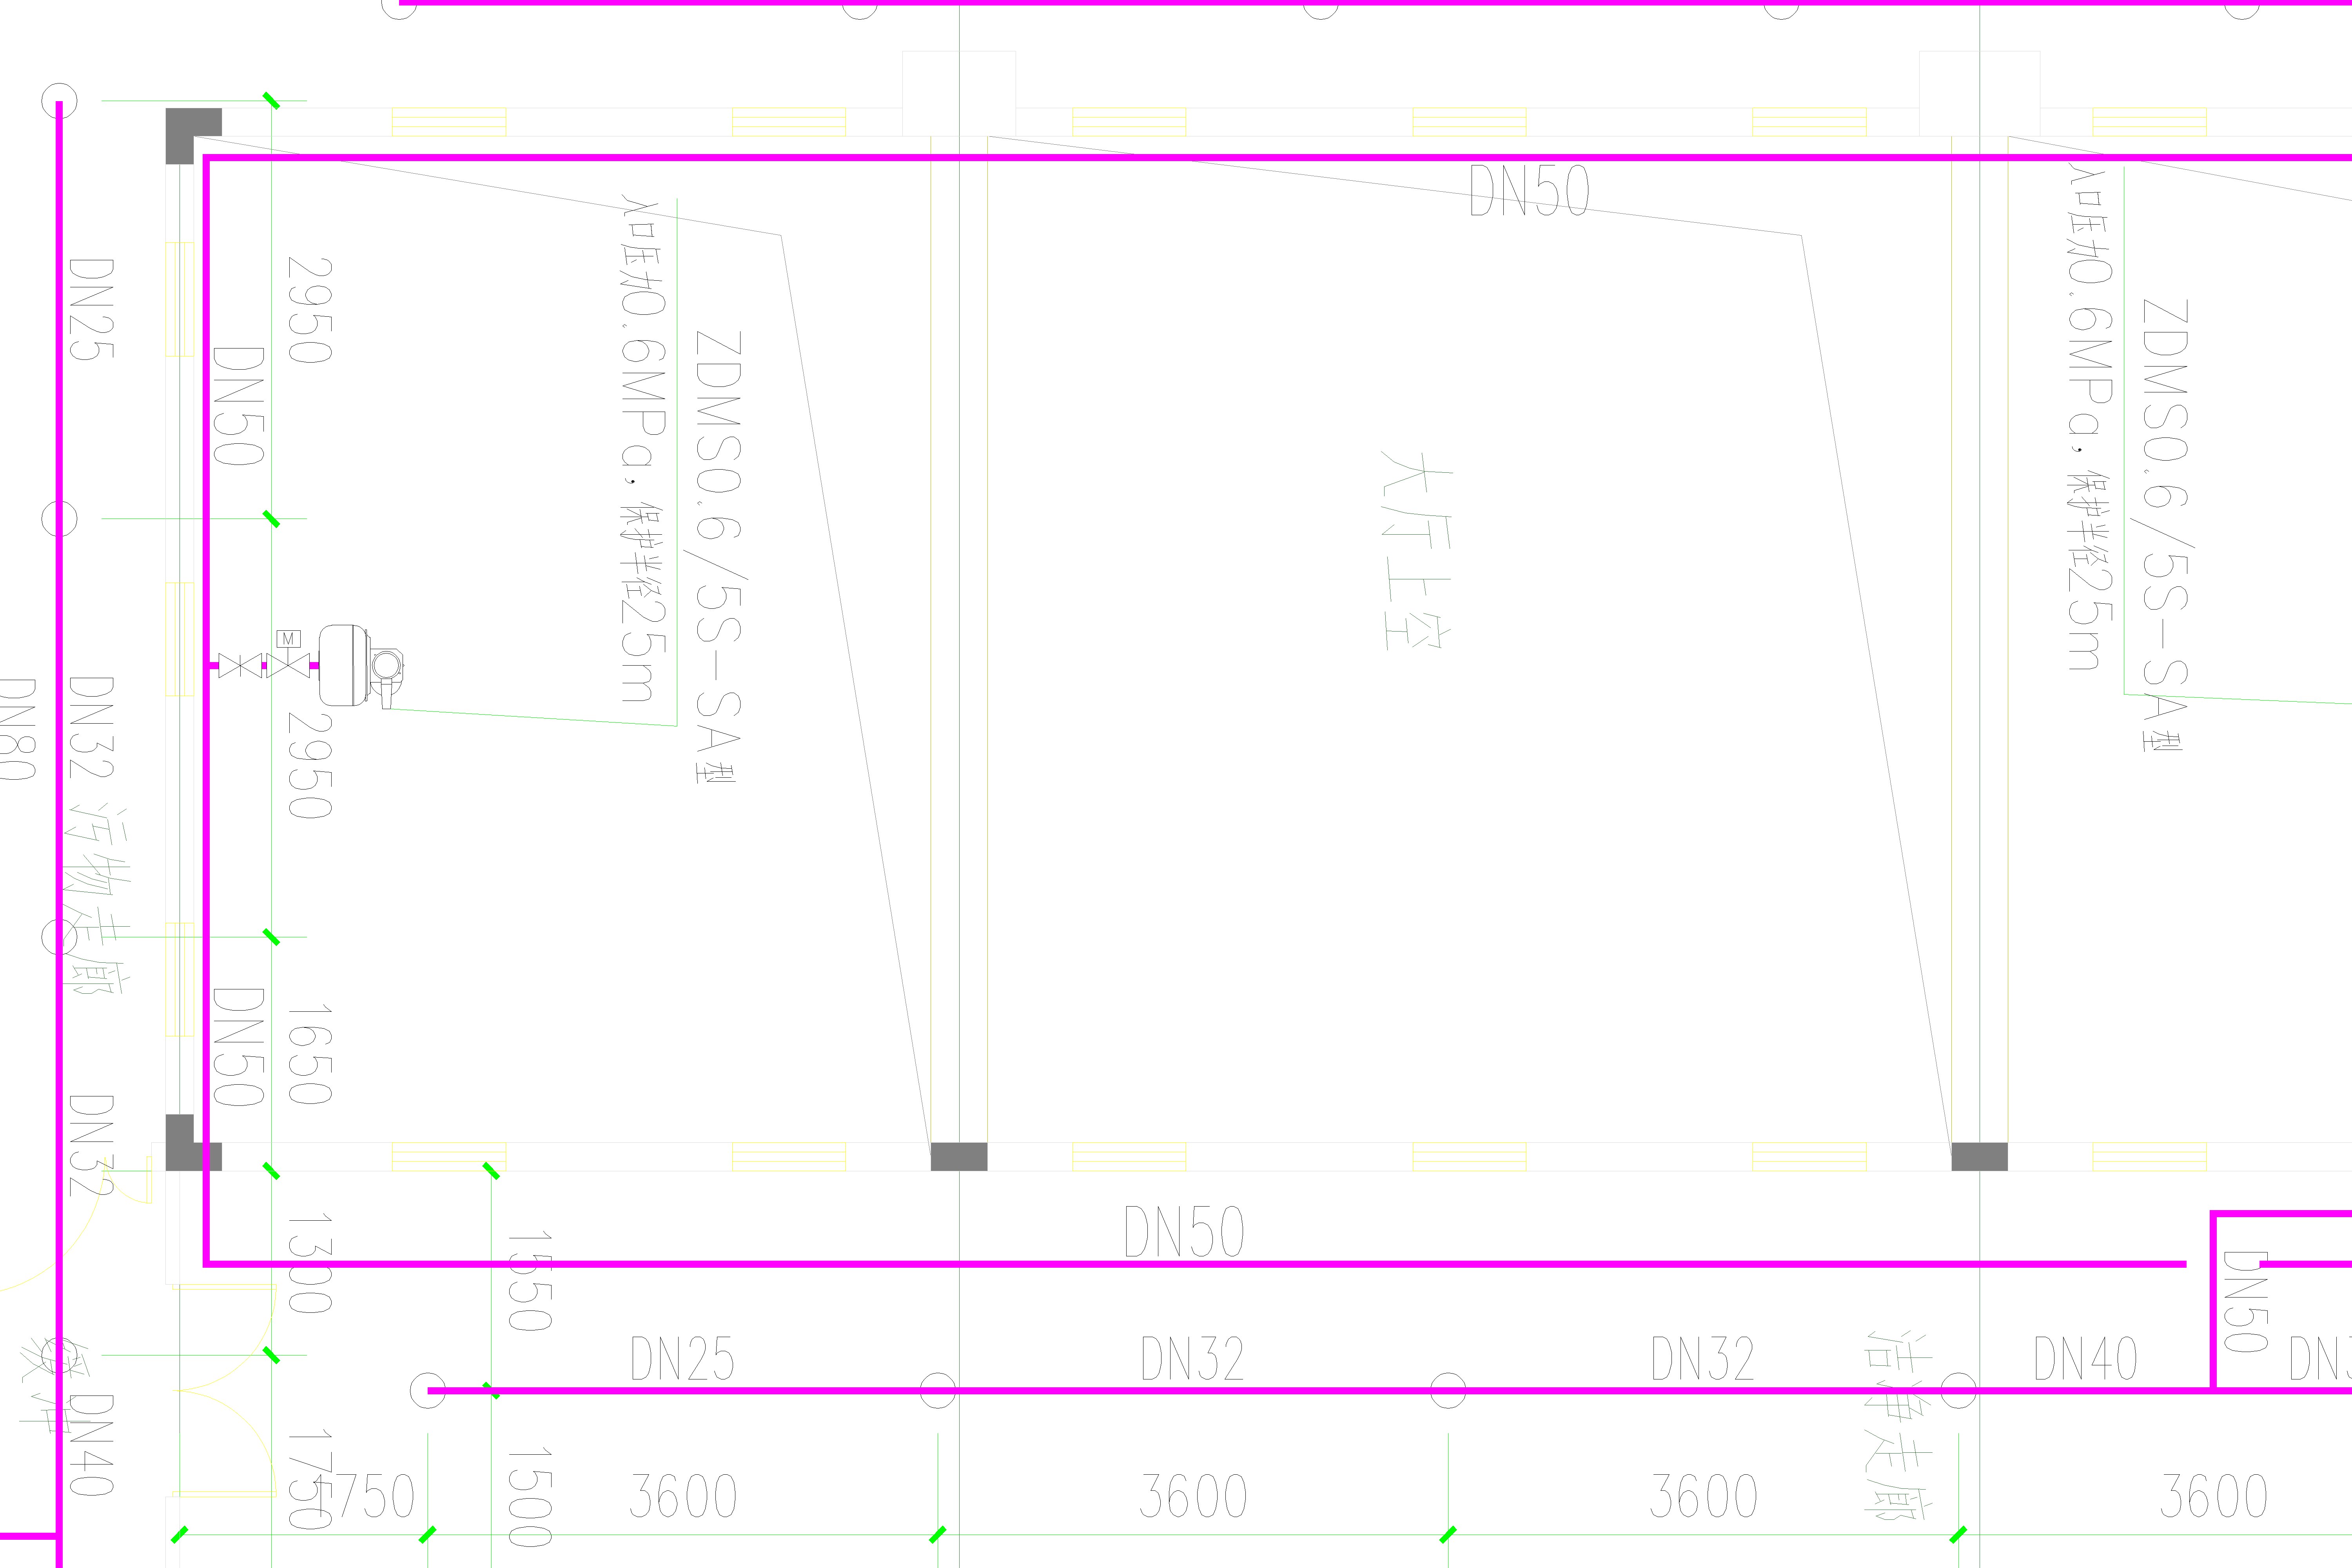

In [3]:
img = cv2.imread('../static/img/b1.png')
img = img[10000:14000, 8500:14500]
Image.fromarray(img).show()

In [4]:
Image.fromarray(img).show()

In [52]:
lines, elines, alone = _detect_one_img(img, get_cfg_defaults())

In [53]:
len(lines), len(alone)

(3374, 466)

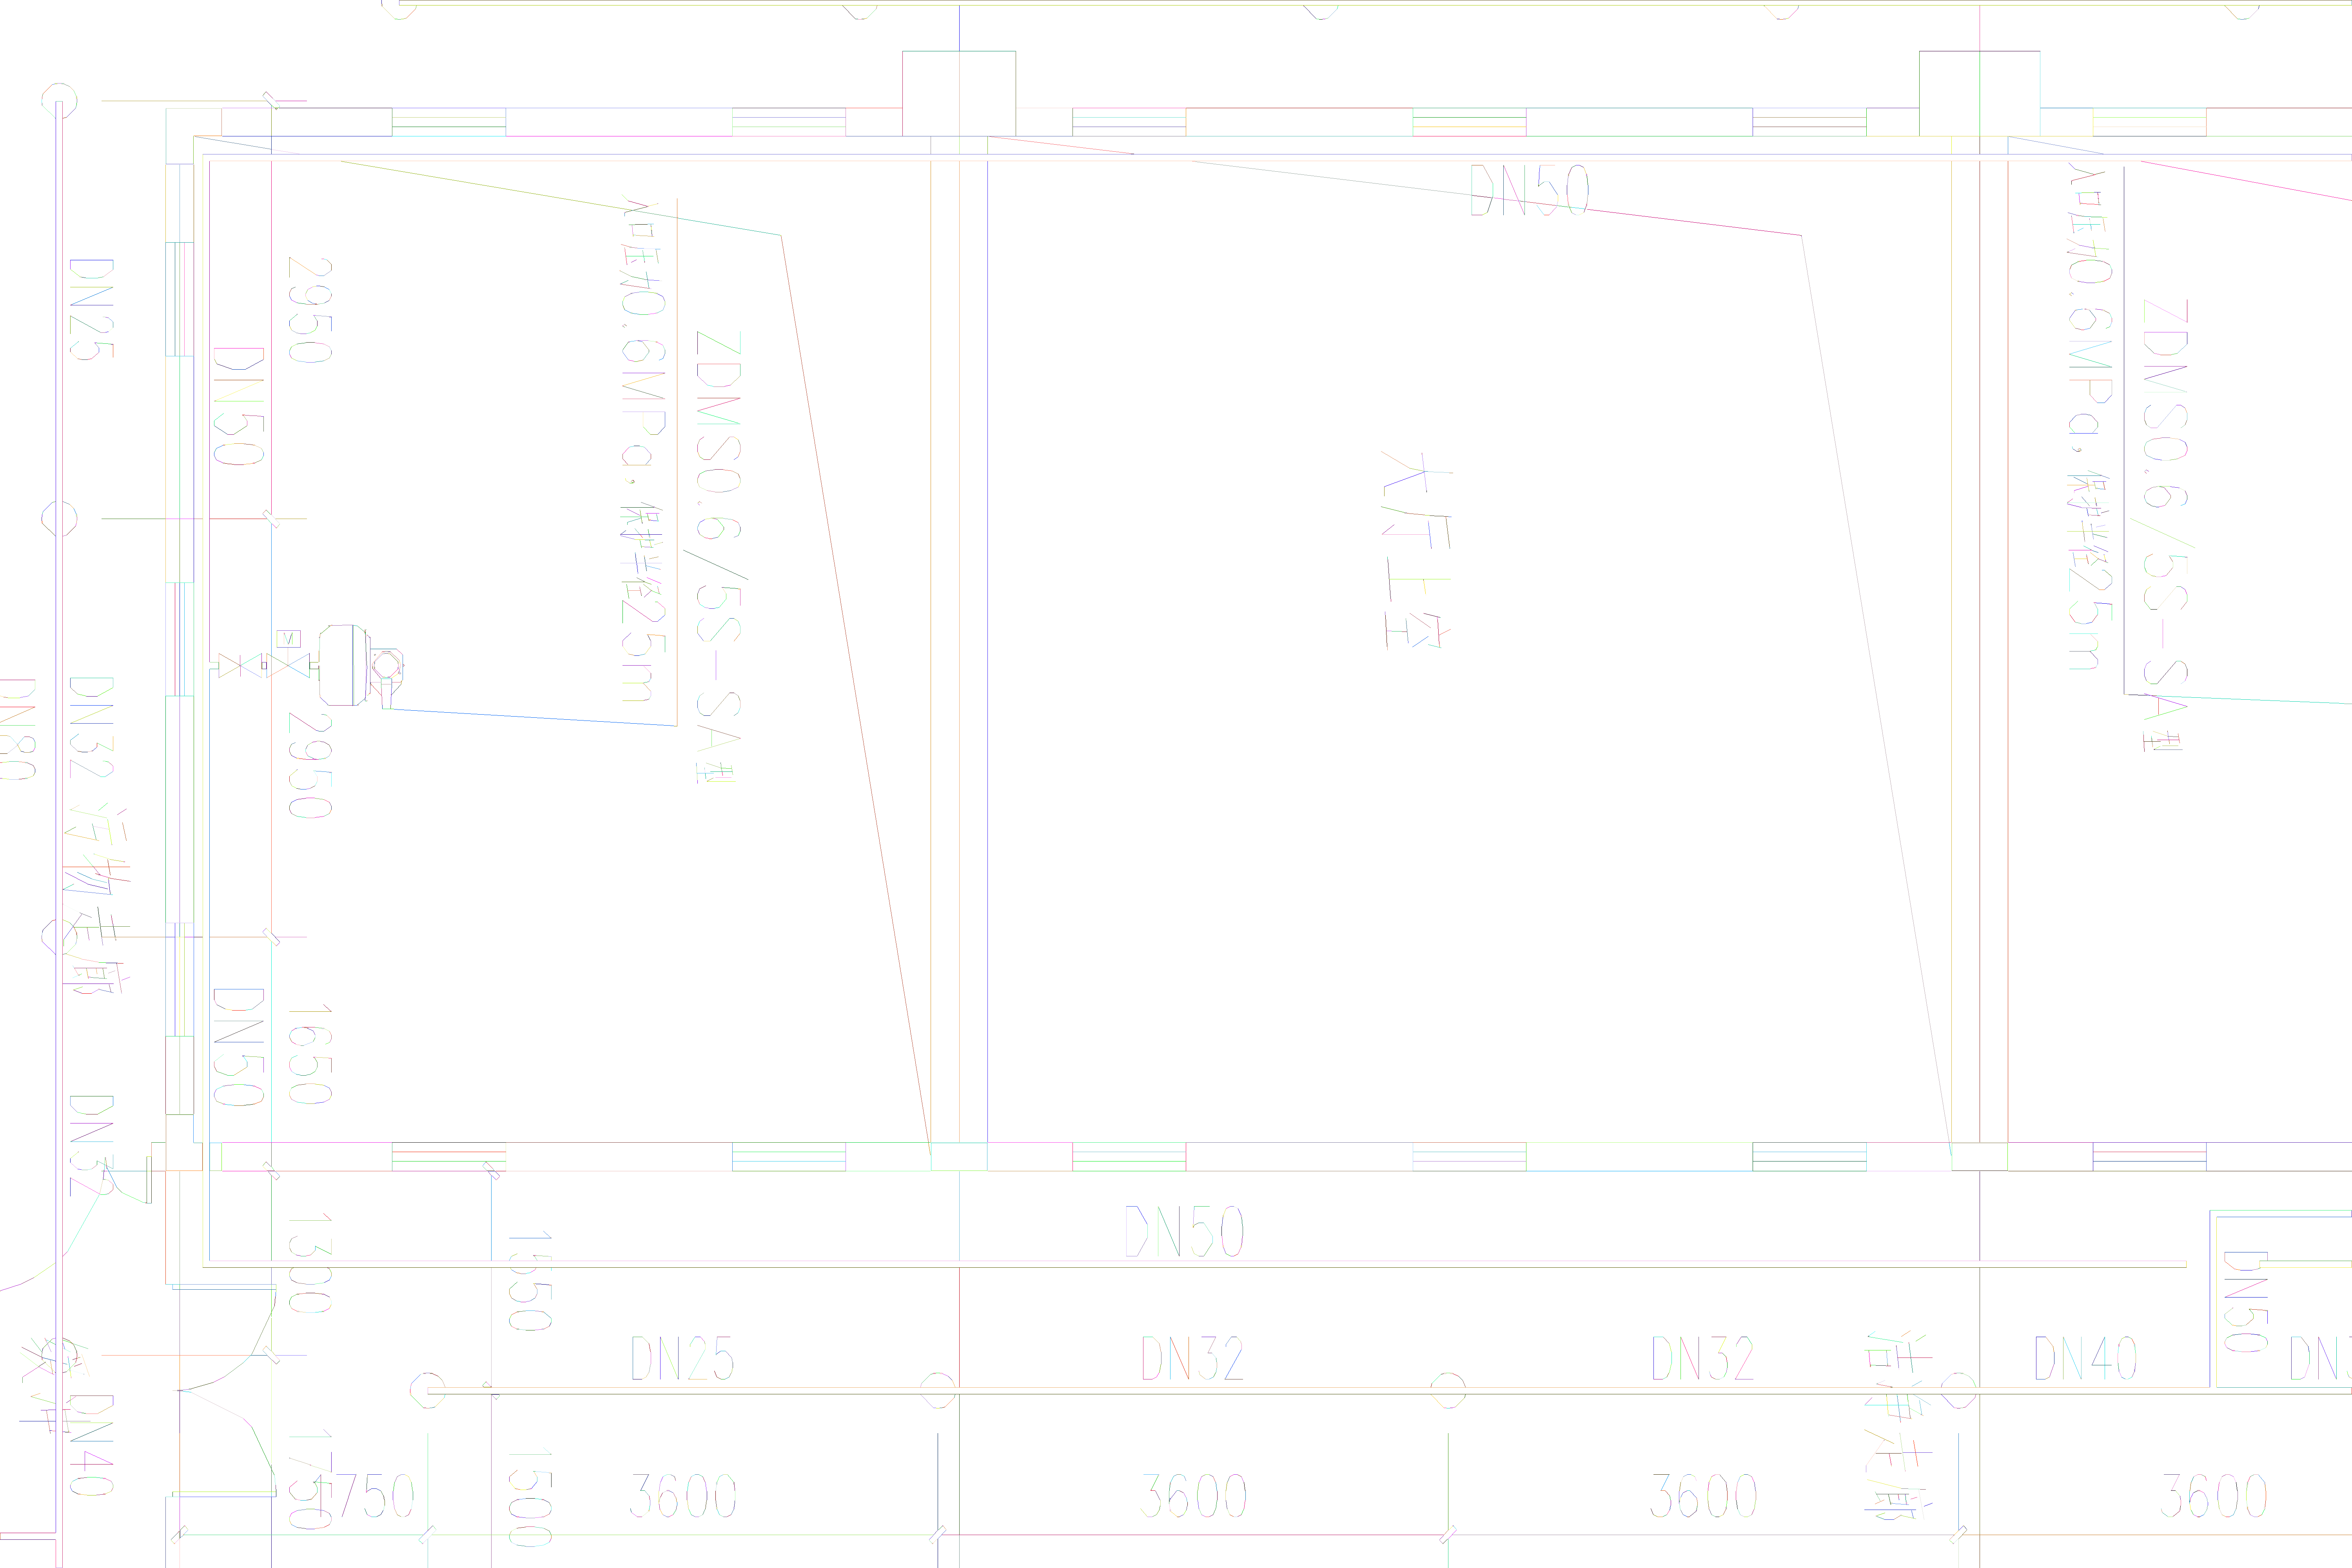

In [54]:
white = np.ones_like(img) * 255
for line in alone:
    color = (255, 230, 230)
    pt1 = line.pt1
    pt2 = line.pt2
    cv2.line(white, pt1, pt2, color, 3)
for line in lines:
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    pt1 = line[0]
    pt2 = line[1]
    cv2.line(white, pt1, pt2, color, 1)
Image.fromarray(white).show()
Image.fromarray(white)

In [30]:
lines

[[(60, 2412), (75, 2443), (255, 255, 0)],
 [(75, 2886), (63, 2911), (255, 255, 0)],
 [(1551, 1420), (1570, 1459), (57, 114, 57)],
 [(1280, 125), (1349, 159), (0, 0, 0)],
 [(141, 758), (196, 771), (57, 114, 57)],
 [(157, 851), (188, 866), (57, 114, 57)],
 [(1582, 1487), (1607, 1475), (57, 114, 57)],
 [(52, 2025), (93, 2045), (0, 0, 0)],
 [(920, 2025), (961, 2045), (0, 0, 0)],
 [(1715, 2066), (1756, 2086), (0, 0, 0)],
 [(2890, 2066), (2909, 2075), (0, 0, 0)],
 [(2913, 2077), (2932, 2086), (0, 0, 0)],
 [(920, 2703), (961, 2723), (0, 0, 0)],
 [(1280, 2748), (1349, 2782), (0, 0, 0)],
 [(1959, 2787), (1980, 2777), (255, 255, 0)],
 [(1715, 2909), (1756, 2929), (0, 0, 0)],
 [(2890, 2909), (2909, 2918), (0, 0, 0)],
 [(2913, 2920), (2932, 2929), (0, 0, 0)],
 [(426, 2982), (439, 2969), (57, 114, 57)],
 [(3, 2336), (13, 2346), (255, 255, 0)],
 [(1646, 419), (1655, 428), (0, 0, 0)],
 [(1869, 2856), (1880, 2845), (255, 255, 0)],
 [(2821, 1468), (2830, 1477), (0, 0, 0)],
 [(1883, 2843), (1893, 2833),

In [27]:
len(alone)

682

In [24]:
len(alone)

706

In [1]:
from utils.detect_line import *
ori_img = cv2.imread('../static/img/1.png')
ori_img = ori_img[8900:9000, 9050:9170]

elines = get_eline_faster(ori_img, get_cfg_defaults())

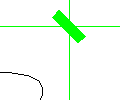

In [2]:
Image.fromarray(ori_img)

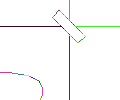

In [3]:
white = np.ones_like(ori_img, dtype=np.uint8) * 255
for eline in elines:
    pt1 = eline.pt1
    pt2 = eline.pt2
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(white, pt1, pt2, color, 1)
Image.fromarray(white)

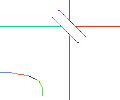

In [4]:
white = np.ones_like(ori_img, dtype=np.uint8) * 255
for eline in elines:
    if not eline.dir_eq([1,0, 0, 0]):
        continue
    pt1 = eline.pt1
    pt2 = eline.pt2
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(white, pt1, pt2, color, 1)
Image.fromarray(white)

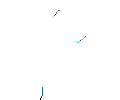

In [5]:
white = np.ones_like(ori_img, dtype=np.uint8) * 255
for eline in elines:
    if not eline.dir_eq([0,1, 0, 0]):
        continue
    pt1 = eline.pt1
    pt2 = eline.pt2
    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.line(white, pt1, pt2, color, 1)
Image.fromarray(white)